Todo:
- fit style to figs in thesis. so bold fonts fofr axis titles, thicker axis lines, sort legends
- figure out why bombing happend at 2am. is it rare occurences? 
- probs need some statistical model to see if there is a pattern? though im not sure if that really adds much value
- aks agung if they haev any of the missing data gaps/to prioritise these.
- make training performance plots?
- write up!
- Todo: 1) Make map with inse, use the bomb localisation code (add coords on axis). 2) plot bombs v augmented, use the exisitng files and fig from the global acoustic chapters code. 3) get auprc plot again (or put in but leave note to improve?). 4) copy mode architiecture from inference notebook into soemthign that cna maek model.
- arch: remake. label myself in powerpoint. Labels each layer and have H, W, F optionals. Label dropout and flatten layers on lines.


In [2]:
import os
from datetime import datetime, timedelta, date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
# Global variables
# Base directory from environment
BASE_DIR = os.getenv("BASE_DIR")
if not BASE_DIR:
    raise ValueError("BASE_DIR must be set")

CSV_FOLDER: str = os.path.join(BASE_DIR, "bomb_fishing/data/mars_outputs")
BOMB_KEYWORDS = {"y", "Y", "yes", "bomb"} # keywords used by team to denote a bomb

### Plot time series

In [4]:

def load_data_by_recorder(csv_folder: str, recorder_prefix: str) -> pd.DataFrame:
    """Load and concatenate CSV files for a given north/south recorder prefix.

    Args:
        csv_folder: Path to the folder containing CSV files.
        recorder_prefix: Prefix of files to load (e.g., 'north' or 'south').

    Returns:
        DataFrame with parsed 'datetime' and 'bomb_detected' columns.
    """
    file_list = [
        os.path.join(csv_folder, f)
        for f in os.listdir(csv_folder)
        if f.lower().startswith(recorder_prefix.lower()) and f.lower().endswith(".csv")
    ]
    if not file_list:
        raise FileNotFoundError(f"No CSV files found for region '{recorder_prefix}'.")
    df_list = [pd.read_csv(fp) for fp in file_list]
    df = pd.concat(df_list, ignore_index=True)
    # Parse datetime from File column
    df["datetime"] = (
        df["File"].str.replace(".WAV", "", regex=False)
        .apply(lambda x: datetime.strptime(x, "%Y%m%d_%H%M%S"))
    )
    # Flag bomb detections
    df["bomb_detected"] = (
        df["Bombs"].astype(str).str.lower().isin(BOMB_KEYWORDS)
    )
    return df


def aggregate_daily_counts(df: pd.DataFrame) -> (pd.Series, pd.Series):
    """Aggregate bomb detections and recording presence by day.

    Args:
        df: DataFrame with 'datetime' and 'bomb_detected'.

    Returns:
        Tuple of two Series indexed by date:
          - bombs_per_day: count of detections per day.
          - recordings_per_day: count of recordings per day.
    """
    df["date"] = df["datetime"].dt.date
    all_dates = pd.date_range(start=df["date"].min(), end=df["date"].max(), freq="D")
    bombs_count = df.loc[df["bomb_detected"]].groupby("date").size()
    recordings_count = df.groupby("date").size()
    bombs_count = bombs_count.reindex(all_dates.date, fill_value=0)
    recordings_count = recordings_count.reindex(all_dates.date, fill_value=0)
    bombs_count.index = pd.to_datetime(bombs_count.index)
    recordings_count.index = pd.to_datetime(recordings_count.index)
    return bombs_count, recordings_count


def find_gap_spans(recordings_count: pd.Series) -> list[tuple[date, date]]:
    """Identify contiguous spans of days with no recordings.

    Args:
        recordings_count: Series indexed by datetime, values are counts per day.

    Returns:
        List of (start_date, end_date) tuples for each gap.
    """
    gap_days = [d.date() for d, c in recordings_count.items() if c == 0]
    if not gap_days:
        return []
    gap_days_sorted = sorted(gap_days)
    spans = []
    start = prev = gap_days_sorted[0]
    for current in gap_days_sorted[1:]:
        if current == prev + timedelta(days=1):
            prev = current
        else:
            spans.append((start, prev))
            start = prev = current
    spans.append((start, prev))
    return spans

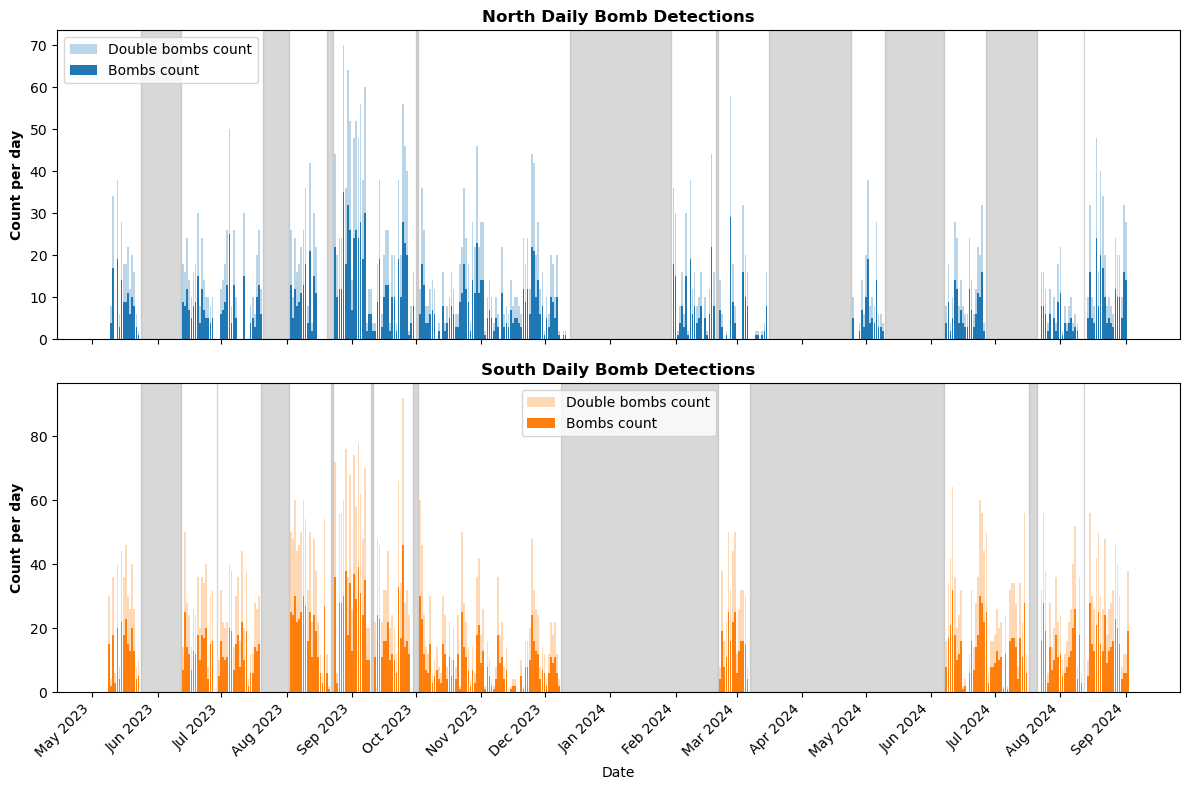

In [5]:
def plot_bomb_time_series(csv_folder: str) -> None:
    """Plot daily bomb counts with recording gaps shaded *between* bars."""
    recorders = ["north", "south"]
    fig, axes = plt.subplots(len(recorders), 1, sharex=True, figsize=(12, 8))
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    bar_width = 0.8                           # days
    half_width = bar_width / 2

    for ax, recorder, color in zip(axes, recorders, colors):
        df = load_data_by_recorder(csv_folder, recorder)
        bombs_count, recordings_count = aggregate_daily_counts(df)
        gap_spans = find_gap_spans(recordings_count)
        dates = bombs_count.index

        # Shade gaps *between* bars, inset by half_width days on each side:
        for start, end in gap_spans:
            ax.axvspan(
                start + timedelta(days=half_width),
                end + timedelta(days=1 - half_width),
                color="grey",
                alpha=0.3,
                zorder=0,
            )

        # Plot the double‐height “background” bars
        ax.bar(
            dates,
            bombs_count * 2,
            width=bar_width,
            color=color,
            alpha=0.3,
            label="Double bombs count",
            zorder=1,
        )
        # Plot the real counts on top
        ax.bar(
            dates,
            bombs_count,
            width=bar_width,
            color=color,
            label="Bombs count",
            zorder=2,
        )

        ax.set_title(f"{recorder.capitalize()} Daily Bomb Detections", fontweight="bold")
        ax.set_ylabel("Count per day", fontweight="bold")
        ax.legend()

    # Tidy up dates
    axes[-1].xaxis.set_major_locator(mdates.MonthLocator())
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    fig.autofmt_xdate(rotation=45)
    plt.xlabel("Date")
    fig.tight_layout()
    plt.show()

plot_bomb_time_series(CSV_FOLDER)

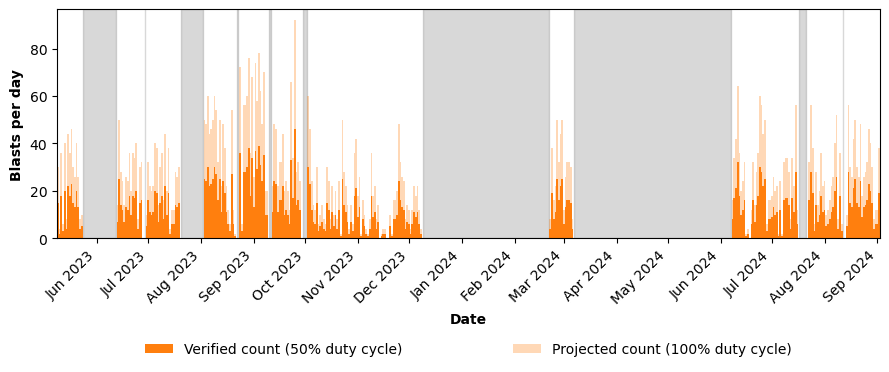

In [6]:
# South-only daily bomb detections


# Parameters
recorder = "south"
bar_width = 1                    # in days
half_width = bar_width / 2
colours = plt.rcParams["axes.prop_cycle"].by_key()["color"]
colour = colours[1] # gets that nice contrasting ornage colour

# Load & aggregate
df = load_data_by_recorder(CSV_FOLDER, recorder)
bombs_count, recordings_count = aggregate_daily_counts(df)
gaps = find_gap_spans(pd.Series(recordings_count.values, index=bombs_count.index))

# Plot setup
fig, ax = plt.subplots(figsize=(9, 4))

# Shade gaps *between* bars
for start, end in gaps:
    ax.axvspan(
        start + timedelta(days=half_width),
        end   + timedelta(days=1 - half_width),
        color="grey",   # use 'color', not 'colour'
        alpha=0.3,
        zorder=0,
    )

# Actual bomb counts
ax.bar(
    bombs_count.index,
    bombs_count.values,
    width=bar_width,
    color=colour,    # use 'color'
    label="Verified count (50% duty cycle)",
    zorder=2,
)

# Double-height “background” bars
ax.bar(
    bombs_count.index,
    bombs_count.values * 2,
    width=bar_width,
    color=colour,    # use 'color'
    alpha=0.3,
    label="Projected count (100% duty cycle)",
    zorder=1,
)


# Formatting
ax.margins(x=0) # remove extra white space on left/right

#ax.set_title("South Daily Bomb Detections")
ax.set_ylabel("Blasts per day", fontweight="bold")
# Horizontal legend below the plot
ax.legend(
    ncol=2,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.4),
    frameon=False,
    columnspacing=8,             # increase this to create more horizontal gap
)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
fig.autofmt_xdate(rotation=45)
plt.xlabel("Date", fontweight="bold")
plt.tight_layout()
save_path = os.path.join(BASE_DIR, "bomb_fishing/data/figures", f"barplot.png")
plt.savefig(save_path, dpi=600, bbox_inches="tight", transparent=True)
plt.show()


### Rose plot

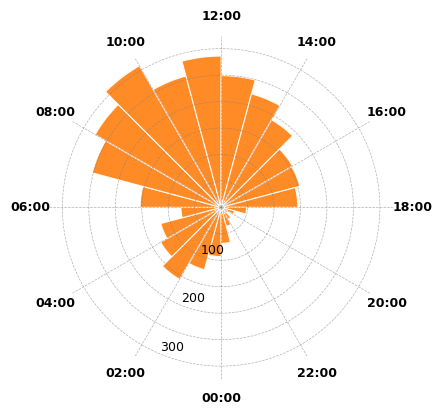

In [7]:
# Rose plot: South Recorder bomb detections by hour,
#   with noon at the top, 2‐hour ticks, and day/night colouring.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from math import pi

# Load & filter for true bomb hits
df = load_data_by_recorder(CSV_FOLDER, "south")
hits = df[df["bomb_detected"]].copy()
hits["hour"] = hits["datetime"].dt.hour

# Count detections by hour (0–23)
hourly_counts = hits.groupby("hour").size().reindex(range(24), fill_value=0)
radii = hourly_counts.values
max_r = radii.max()

# sample 24 colours
colours = plt.rcParams["axes.prop_cycle"].by_key()["color"]
bar_colour = colours[1]   

# Compute angles for each hour
N = 24
angles = (np.arange(24) + 0.5) * (2*pi/24)
width = 2*pi / N

# Plot
fig, ax = plt.subplots(figsize=(4.5, 4.5), subplot_kw={"projection": "polar"})

# Bars
bars = ax.bar(
    angles,
    radii,
    width=width,
    bottom=0,
    color=bar_colour,   
    edgecolor="white",
    linewidth=0.8,
    alpha=0.9,
)

# Aesthetics
ax.set_theta_zero_location("S")   # 0h (midnight) at bottom → 12h (noon) at top
ax.set_theta_direction(-1)        # clockwise increases

# tick every 2 hours
hours = np.arange(0, 24, 2)
ticks = hours * 2*pi/24
ax.set_xticks(ticks)
ax.set_xticklabels([f"{h:02d}:00" for h in hours], fontsize=9, fontweight="bold")

# lighten grid, remove spine
ax.grid(color="grey", linestyle="--", linewidth=0.5, alpha=0.6)
ax.spines["polar"].set_visible(False)

### Radial ticks
#radials = np.linspace(0, max_r, 5)
#ax.set_yticks(radials)
#ax.set_yticklabels([f"{int(r)}" for r in radials], fontsize=10)
### No radial ticks
# radials = np.linspace(0, max_r, 5)
# ax.set_yticks(radials)
# ax.set_yticklabels([])  
### Custom radial ticks 
radial_values = [50, 100, 150, 200, 250, 300]
ax.set_yticks(radial_values)

# Only label every other one: show 100, 200, 300
radial_labels = [str(r) if r % 100 == 0 else "" for r in radial_values]
ax.set_yticklabels(radial_labels, fontsize=9)

plt.tight_layout()
save_path = os.path.join(BASE_DIR, "bomb_fishing/data/figures", f"roseplot.png")
plt.savefig(save_path, dpi=600, bbox_inches="tight", transparent=True)
plt.show()


Makassar sits just south of the equator, so daylight hardly budges over the year – there is only about a 36-minute swing from shortest to longest day. At the June solstice (around 21 June) you’ll see roughly 11 h 49 min of light, and at the December solstice (around 21 December) about 12 h 25 min – that’s it, just half an hour or so difference 
Time and Date
Time and Date
.

In day-to-day life the Sun basically pops up at about 6 am and clocks off at about 6 pm. For instance, on 30 May 2025 it rose at 06:04 am and set at 05:55 pm local time 
Time and Date
. Through the year you’ll only ever see sunrises shift by a few minutes (you won’t catch it before about 05:50 am or after about 06:15 am) and sunsets land between roughly 17:45 and 18:15.

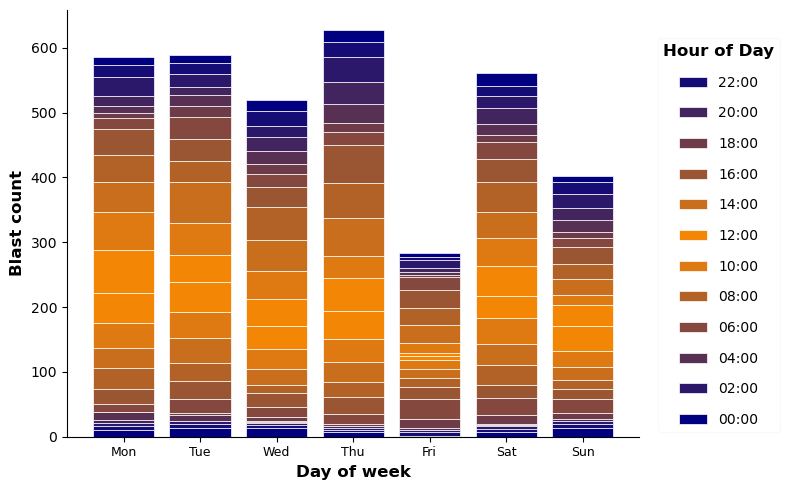

In [8]:
from matplotlib.colors import LinearSegmentedColormap

# Create a pivot table: rows are weekdays (0–6), columns are hours (0–23), values are counts
hits["weekday"] = hits["datetime"].dt.dayofweek
weekday_hour_counts = (
    hits.groupby(["weekday", "hour"])
    .size()
    .unstack(fill_value=0)
    .reindex(index=range(7), fill_value=0)  # ensure all weekdays present
)

# Define two base colours
COLOUR1 = "navy"
COLOUR2 = "darkorange"

# Create a cyclic colormap that goes from COLOUR1 → COLOUR2 → COLOUR1
cyclic_cmap = LinearSegmentedColormap.from_list(
    "two_colour_cycle",
    [COLOUR1, COLOUR2, COLOUR1],
)

# Sample 24 colours from that cyclic map (so 00:00 and 23:00 are both close to COLOUR1)
hour_colours = [cyclic_cmap(i / 23) for i in range(24)]

# Plot stacked bar chart with spines and a pared-down legend
fig, ax = plt.subplots(figsize=(8, 5))

x_positions = range(7)
weekday_names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
bottom = np.zeros(7, dtype=int)

# Loop in reverse so hour 23 is plotted first (at the bottom), then 22, …, down to 0
for hour in reversed(range(24)):
    counts = weekday_hour_counts[hour].values
    # Only label every other hour as before
    label = f"{hour:02d}:00" if hour % 2 == 0 else "_nolegend_"
    ax.bar(
        x_positions,
        counts,
        bottom=bottom,
        color=hour_colours[hour],
        edgecolor="white",
        linewidth=0.5,
        label=label,
    )
    bottom += counts  # stack the next (lower-numbered) hour on top

# Remove top/right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Aesthetics
ax.set_xticks(x_positions)
ax.set_xticklabels(weekday_names, fontsize=9)
ax.set_xlabel("Day of week", fontsize=12, fontweight="bold")
ax.set_ylabel("Blast count", fontsize=12, fontweight="bold")

# Legend
leg = ax.legend(
    title="Hour of Day",
    bbox_to_anchor=(1.02, 0.95),
    loc="upper left",
    fontsize=10,
    title_fontsize=12,
    ncol=1,
    framealpha=0.1,
    labelspacing=1.2,
)
# Plot legend  with bold title font
leg.get_title().set_fontweight("bold")

plt.tight_layout()
plt.tight_layout()
save_path = os.path.join(BASE_DIR, "bomb_fishing/data/figures", "weekdays.png")
plt.savefig(save_path, dpi=600, bbox_inches="tight", transparent=True)
plt.show()


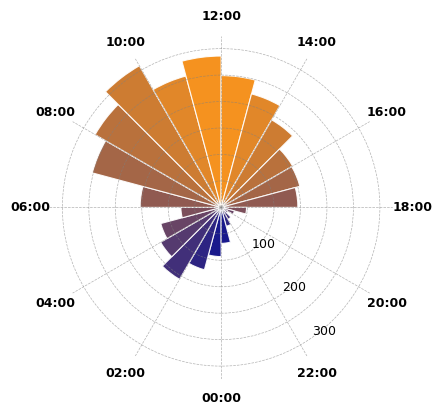

In [9]:
from matplotlib.colors import LinearSegmentedColormap
from math import pi

# Load & filter for true bomb hits
df = load_data_by_recorder(CSV_FOLDER, "south")
hits = df[df["bomb_detected"]].copy()
hits["hour"] = hits["datetime"].dt.hour

# Count detections by hour (0–23)
hourly_counts = hits.groupby("hour").size().reindex(range(24), fill_value=0)
radii = hourly_counts.values
max_r = radii.max()

# Compute angles for each hour slice
N = 24
angles = (np.arange(N) + 0.5) * (2 * pi / N)
width = 2 * pi / N

# Create a two-colour cyclic map (navy → darkorange → navy)
COLOUR1 = "navy"
COLOUR2 = "darkorange"
cyclic_cmap = LinearSegmentedColormap.from_list(
    "two_colour_cycle",
    [COLOUR1, COLOUR2, COLOUR1],
)
# Sample 24 colours so 00:00 & 23:00 are both near navy
hour_colours = [cyclic_cmap(i / (N - 1)) for i in range(N)]

# Plot
fig, ax = plt.subplots(figsize=(4.5, 4.5), subplot_kw={"projection": "polar"})

# Bars: assign each hour its cyclic colour
bars = ax.bar(
    angles,
    radii,
    width=width,
    bottom=0,
    color=hour_colours,
    edgecolor="white",
    linewidth=0.8,
    alpha=0.9,
)

# Aesthetics: noon at top, clockwise progression
ax.set_theta_zero_location("S")
ax.set_theta_direction(-1)

# Tick every 2 hours
hours = np.arange(0, 24, 2)
ticks = hours * 2 * pi / 24
ax.set_xticks(ticks)
ax.set_xticklabels([f"{h:02d}:00" for h in hours], fontsize=9, fontweight="bold")

# Lighten grid, remove polar spine
ax.grid(color="grey", linestyle="--", linewidth=0.5, alpha=0.6)
ax.spines["polar"].set_visible(False)

# Radial ticks (only label 100, 200, 300)
radial_values = [50, 100, 150, 200, 250, 300]
ax.set_yticks(radial_values)
radial_labels = [str(r) if r % 100 == 0 else "" for r in radial_values]
ax.set_yticklabels(radial_labels, fontsize=9)
ax.set_rlabel_position(325) # set the angle the ticks come out at

# plot and save
plt.tight_layout()
save_path = os.path.join(BASE_DIR, "bomb_fishing/data/figures", "roseplot.png")
plt.savefig(save_path, dpi=600, bbox_inches="tight", transparent=True)
plt.show()


## Other stats to report in results

In [10]:

def total_detection_count(csv_folder: str) -> int:
    """Count the total number of rows across all CSV files in a folder.

    Args:
        csv_folder: Path to the folder containing CSV files.

    Returns:
        Total row count (int).
    """
    total = 0
    for fname in os.listdir(csv_folder):
        if fname.lower().endswith(".csv") and fname.lower().startswith("south"):
            fp = os.path.join(csv_folder, fname)
            df = pd.read_csv(fp)
            total += len(df)
    return total

# Run it and print
total_rows = total_detection_count(CSV_FOLDER)
print(f"Total detection count (all rows): {total_rows}")

Total detection count (all rows): 53545


In [11]:
# mean precision across the whole period:
# verified bomb count / detection count
3567 / total_rows 

0.06661686431973107

In [23]:
# Average daily precision per month
def average_daily_precision_per_month(csv_folder: str) -> None:
    """Compute and print average daily precision for each month in the study period.

    'Precision' here is defined as (bombs detected) / (recordings that day).

    Args:
        csv_folder: Path to the folder containing CSV files.
    """
    # Load both sites and concatenate
    df_south = load_data_by_recorder(csv_folder, "south")
    df_all = pd.concat([df_south], ignore_index=True)

    # Aggregate by day
    bombs_per_day, recs_per_day = aggregate_daily_counts(df_all)
    # daily precision series
    precision = bombs_per_day.divide(recs_per_day.replace(0, pd.NA))
    precision = precision.dropna()

    # Group by year-month and compute mean
    precision.index = precision.index.to_period("M")
    monthly_avg = precision.groupby(precision.index).mean()

    # Print in year-month order
    for period, avg in monthly_avg.items():
        year = period.year
        month = period.month
        print(f"{year}-{month:02d}  Avg precision: {avg:.3f}")

# Run it
print("this is daily avg precision per month (next cell is whole month):")
average_daily_precision_per_month(CSV_FOLDER)
# note it used the rolling avg so be sure to only take months below that are not greyed out in plots.


this is daily avg precision per month (next cell is whole month):
2023-05  Avg precision: 0.221
2023-06  Avg precision: 0.121
2023-07  Avg precision: 0.151
2023-08  Avg precision: 0.268
2023-09  Avg precision: 0.286
2023-10  Avg precision: 0.183
2023-11  Avg precision: 0.119
2023-12  Avg precision: 0.167
2024-02  Avg precision: 0.017
2024-03  Avg precision: 0.010
2024-06  Avg precision: 0.102
2024-07  Avg precision: 0.095
2024-08  Avg precision: 0.247
2024-09  Avg precision: 0.399


In [ ]:
#Monthly weighted precision with recording-day counts and warnings
import pandas as pd

def monthly_weighted_precision_with_counts(csv_folder: str) -> None:
    """Compute and print each month's overall precision (total bombs ÷ total detections),
    along with the number of recording days. Warn if a month has fewer than 15 recording days.

    Args:
        csv_folder: Path to the folder containing CSV files.
    """
    # Load south‐only data (or include north if desired)
    df_south = load_data_by_recorder(csv_folder, "south")
    df_all = pd.concat([df_south], ignore_index=True)

    # Aggregate bombs and recordings per calendar day
    bombs_per_day, recs_per_day = aggregate_daily_counts(df_all)
    daily = pd.DataFrame({
        "bombs": bombs_per_day,
        "recs":  recs_per_day
    })

    # Restrict to days with at least one detection (i.e., recording days)
    recorded_days = daily[daily["recs"] > 0].copy()
    recorded_days["year_month"] = recorded_days.index.to_period("M")

    # For each month, sum bombs, sum detections, and count recording days
    monthly = (
        recorded_days
        .groupby("year_month")
        .agg(
            total_bombs=("bombs", "sum"),
            total_recs=("recs", "sum"),
            rec_days=("bombs", "count")
        )
        .assign(
            precision=lambda df: df["total_bombs"] / df["total_recs"]
        )
    )

    # Print header
    print("Year-Month │ Precision │ Recording Days │ Warning")
    print("---------- │ --------- │ -------------- │ -----------------")
    # Iterate in chronological order
    for period, row in monthly.iterrows():
        year = period.year
        month = period.month
        prec = row["precision"]
        days = int(row["rec_days"])
        warning = "⚠️ Less than 15 rec days" if days < 15 else ""
        print(f"{year}-{month:02d}    │   {prec:.3f}   │       {days:2d}        │ {warning}")

# Run it
monthly_weighted_precision_with_counts(CSV_FOLDER)


Year-Month │ Precision │ Recording Days │ Warning
---------- │ --------- │ -------------- │ -----------------
2023-05    │   0.109   │       15        │ 
2023-06    │   0.117   │       17        │ 
2023-07    │   0.087   │       19        │ 
2023-08    │   0.256   │       27        │ 
2023-09    │   0.282   │       27        │ 
2023-10    │   0.169   │       29        │ 
2023-11    │   0.095   │       30        │ 
2023-12    │   0.168   │        8        │ ⚠️ Less than 15 rec days
2024-02    │   0.018   │        8        │ ⚠️ Less than 15 rec days
2024-03    │   0.011   │        6        │ ⚠️ Less than 15 rec days
2024-06    │   0.047   │       23        │ 
2024-07    │   0.019   │       26        │ 
2024-08    │   0.243   │       30        │ 
2024-09    │   0.417   │        2        │ ⚠️ Less than 15 rec days


In [26]:
# Average count of detections per recording day in each calendar month
def avg_detections_per_rec_day_per_month(csv_folder: str) -> None:
    """Compute and print the average number of detections per recording day for each calendar month.

    If a month has fewer than 15 recorded days, a warning is printed next to it.

    Args:
        csv_folder: Path to the folder containing CSV files.
    """
    # Load both sites and concatenate
    df_south = load_data_by_recorder(csv_folder, "south")
    df_all = pd.concat([df_south], ignore_index=True)

    # Aggregate by day
    bombs_per_day, recs_per_day = aggregate_daily_counts(df_all)
    # Combine into a DataFrame
    daily = pd.DataFrame({
        "bombs": bombs_per_day,
        "recs": recs_per_day
    })
    # Only consider days with recordings
    recorded_days = daily[daily["recs"] > 0].copy()
    recorded_days["year_month"] = recorded_days.index.to_period("M")

    # For each year-month, sum bombs and count recording days
    grouped = recorded_days.groupby("year_month")
    for period, group in grouped:
        year = period.year
        month = period.month
        total_bombs = group["bombs"].sum()
        rec_days = len(group)
        avg_per_day = total_bombs / rec_days if rec_days > 0 else 0.0
        warning = "⚠️ Less than 15 rec days" if rec_days < 15 else ""
        print(f"{year}-{month:02d}  Avg bombs/rec day: {avg_per_day:.2f}  ({rec_days} rec days) {warning}")

# Run it
print(" Precision across full month (for recording days only)")
avg_detections_per_rec_day_per_month(CSV_FOLDER)
# not this should be doubled due to the duty cycle!


 Precision across full month (for recording days only)
2023-05  Avg bombs/rec day: 13.00  (15 rec days) 
2023-06  Avg bombs/rec day: 12.53  (17 rec days) 
2023-07  Avg bombs/rec day: 12.74  (19 rec days) 
2023-08  Avg bombs/rec day: 21.11  (27 rec days) 
2023-09  Avg bombs/rec day: 19.52  (27 rec days) 
2023-10  Avg bombs/rec day: 10.24  (29 rec days) 
2023-11  Avg bombs/rec day: 6.83  (30 rec days) 
2023-12  Avg bombs/rec day: 6.62  (8 rec days) ⚠️ Less than 15 rec days
2024-02  Avg bombs/rec day: 16.25  (8 rec days) ⚠️ Less than 15 rec days
2024-03  Avg bombs/rec day: 11.67  (6 rec days) ⚠️ Less than 15 rec days
2024-06  Avg bombs/rec day: 14.00  (23 rec days) 
2024-07  Avg bombs/rec day: 12.04  (26 rec days) 
2024-08  Avg bombs/rec day: 13.50  (30 rec days) 
2024-09  Avg bombs/rec day: 12.50  (2 rec days) ⚠️ Less than 15 rec days


In [27]:
# Highest single-day bomb count
def highest_daily_bomb_count(csv_folder: str) -> None:
    """Find and print the date with the highest number of bombs in a single day.

    Args:
        csv_folder: Path to the folder containing CSV files.
    """
    # Load south-only data (or combine north/south if you prefer)
    df_south = load_data_by_recorder(csv_folder, "south")

    # Get daily bomb counts
    bombs_per_day, _ = aggregate_daily_counts(df_south)

    # Identify the maximum
    max_bombs: int = int(bombs_per_day.max())
    max_day: date = bombs_per_day.idxmax().date()

    print(f"Highest bomb count in one day: {max_bombs} on {max_day}")

# Run it
highest_daily_bomb_count(CSV_FOLDER)


Highest bomb count in one day: 46 on 2023-09-25


In [14]:
# Percentage of bombs between 06:00 and 18:00
import pandas as pd

def percent_bombs_daytime(csv_folder: str) -> None:
    """Compute and print the percentage of bomb detections that occurred between 06:00 and 18:00.

    Args:
        csv_folder: Path to the folder containing CSV files.
    """
    # Load south (or both, depending on whether north matters; here we use both)
    df_north = load_data_by_recorder(csv_folder, "north")
    df_south = load_data_by_recorder(csv_folder, "south")
    df_all = pd.concat([df_north, df_south], ignore_index=True)

    # Filter only bomb hits
    hits = df_all[df_all["bomb_detected"]].copy()
    hits["hour"] = hits["datetime"].dt.hour

    total_hits = len(hits)
    daytime_hits = hits.loc[hits["hour"].between(6, 17)].shape[0]
    if total_hits == 0:
        print("No bombs detected at all.")
        return

    pct = (daytime_hits / total_hits) * 100
    print(f"Bombs between 06:00–18:00: {daytime_hits} of {total_hits} ({pct:.1f}%)")

# Run it
percent_bombs_daytime(CSV_FOLDER)


Bombs between 06:00–18:00: 4139 of 5863 (70.6%)


In [15]:
# Cell: Average bombs per recording-day by weekday
import pandas as pd

def avg_bombs_per_rec_day_by_weekday(csv_folder: str) -> None:
    """Compute the average number of bombs per recording-day for each weekday (Mon=0 … Sun=6)."""

    # Load and concatenate both north/south
    df_south = load_data_by_recorder(csv_folder, "south")
    df_all = pd.concat([df_south], ignore_index=True)

    # Get bombs and recordings counts per calendar day
    bombs_per_day, recs_per_day = aggregate_daily_counts(df_all)

    # Build a DataFrame with only days that actually have recordings
    daily = pd.DataFrame({
        "date": bombs_per_day.index,
        "bombs": bombs_per_day.values,
        "recs": recs_per_day.values,
    })
    recorded = daily[daily["recs"] > 0].copy()

    # Extract weekday (0=Mon … 6=Sun) from the date
    recorded["weekday"] = recorded["date"].dt.dayofweek

    # Now average bombs over only those days with recordings, grouped by weekday
    weekday_avg_rec = recorded.groupby("weekday")["bombs"].mean()

    weekday_names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    for wd, avg in weekday_avg_rec.items():
        name = weekday_names[wd]
        print(f"{name}: {avg:.2f} bombs per recording-day on average")

# Run it
avg_bombs_per_rec_day_by_weekday(CSV_FOLDER)


Mon: 15.84 bombs per recording-day on average
Tue: 14.72 bombs per recording-day on average
Wed: 13.66 bombs per recording-day on average
Thu: 16.50 bombs per recording-day on average
Fri: 7.26 bombs per recording-day on average
Sat: 14.76 bombs per recording-day on average
Sun: 10.86 bombs per recording-day on average


### Plot precision

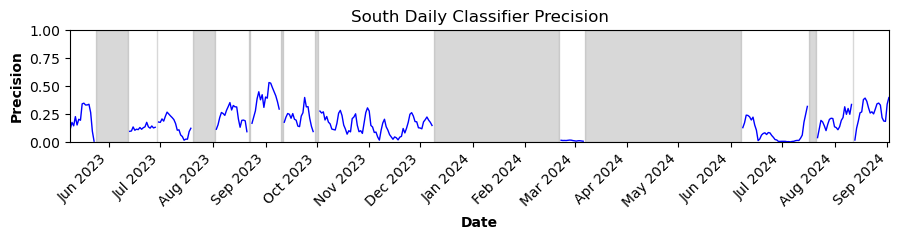

In [16]:
# South-only daily classifier precision plot (masking grey periods)

# Parameters
recorder = "south"
bar_width = 1.0    # days
half_width = bar_width / 2  # inset for shading
smoothing_window = 3   # days for rolling mean

# Load data and add 'date'
df = load_data_by_recorder(CSV_FOLDER, recorder).copy()
df['date'] = df['datetime'].dt.date

# Get daily bomb counts and total detections
bombs_count, recordings_count = aggregate_daily_counts(df)

# Compute daily precision (true positives / hits), avoid divide-by-zero
precision = bombs_count / recordings_count.replace(0, np.nan)

# Smooth precision with rolling mean
smoothed = precision.rolling(
    window=smoothing_window,
    center=True,
    min_periods=1
).mean()

# Mask out days with no recordings so the line skips grey gaps
smoothed[recordings_count == 0] = np.nan

# Identify gaps for shading
gaps = find_gap_spans(recordings_count)

# Plot
fig, ax = plt.subplots(figsize=(9, 2.5))

# Shade no-recording gaps
for start, end in gaps:
    ax.axvspan(
        start + timedelta(days=half_width),
        end   + timedelta(days=1 - half_width),
        color="grey",
        alpha=0.3,
        zorder=0,
    )

# Plot smoothed precision line
ax.plot(
    smoothed.index,
    smoothed.values,
    color="blue",
    linewidth=1,
    label=f"{smoothing_window}-day rolling precision",
    zorder=1,
)

# Formatting
ax.set_ylim(0, 1)
ax.margins(x=0)
ax.set_title("South Daily Classifier Precision")
ax.set_ylabel("Precision", fontweight="bold")
#ax.legend(loc="upper right")
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
fig.autofmt_xdate(rotation=45)
plt.xlabel("Date", fontweight="bold")
plt.tight_layout()
save_path = os.path.join(BASE_DIR, "bomb_fishing/data/figures", f"precisionplot.png")
plt.savefig(save_path, dpi=600, bbox_inches="tight", transparent=True)
plt.show()


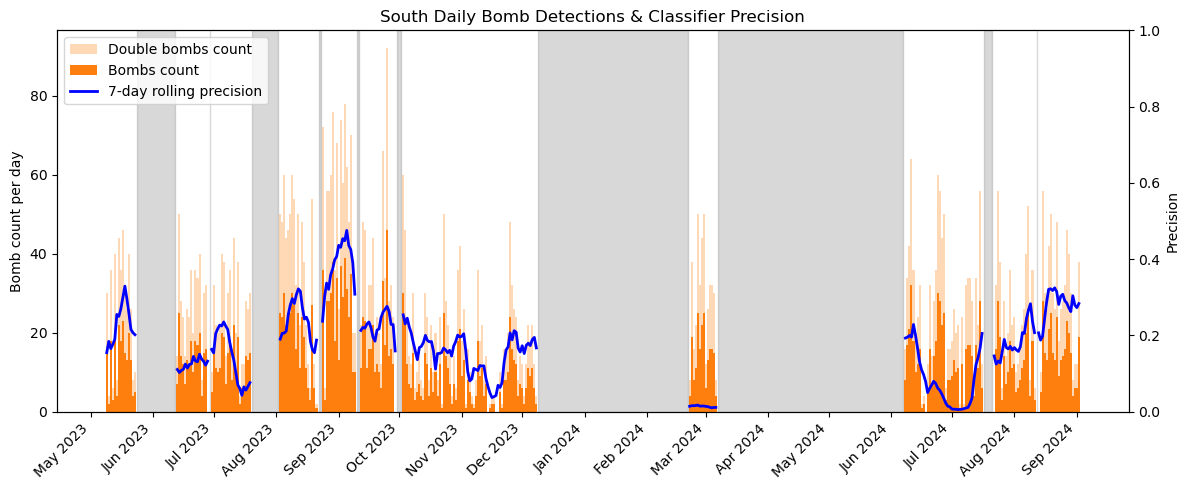

In [17]:
# Combined South bombardment & precision with dual y-axes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta

# Parameters
recorder         = "south"
bar_width        = 1.0                      # width of each bar in days
half_width       = bar_width / 2            # inset for gap shading
smoothing_window = 7                        # days for rolling mean
colours          = plt.rcParams["axes.prop_cycle"].by_key()["color"]
bar_colour       = colours[1]               # orange
line_colour      = "blue"                   # precision line

# 1) Load & prepare data
df = load_data_by_recorder(CSV_FOLDER, recorder).copy()
df["date"] = df["datetime"].dt.date

# 2) Daily bomb counts (true positives) and recording hits (all entries)
daily_hits = df.groupby("date").size()                      # total flagged hits/day
daily_true = df[df["bomb_detected"]].groupby("date").size() # validated bombs/day

# 3) Align to full date range
all_days = pd.date_range(daily_hits.index.min(), daily_hits.index.max(), freq="D").date
hits = daily_hits.reindex(all_days, fill_value=0)
true = daily_true.reindex(all_days, fill_value=0)
dates = pd.to_datetime(all_days)

# 4) Compute precision only on days with hits
precision = true / hits.replace(0, np.nan)

# 5) Smooth precision
smoothed = precision.rolling(window=smoothing_window, center=True, min_periods=1).mean()

# 6) Identify no‐recording gaps for shading
_, recordings_count = aggregate_daily_counts(df)
gaps = find_gap_spans(recordings_count)

# 7) Break the line over gaps: mask smoothed where no recordings
smoothed[recordings_count == 0] = np.nan

# 8) Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 5))
ax2 = ax1.twinx()

# 9) Shade gaps on ax1 (covers background of both axes)
for start, end in gaps:
    ax1.axvspan(
        start + timedelta(days=half_width),
        end   + timedelta(days=1 - half_width),
        color="grey",
        alpha=0.3,
        zorder=0,
    )

# 10) Plot bomb counts on ax1
ax1.bar(
    dates,
    true.values * 2,        # double-height background
    width=bar_width,
    color=bar_colour,
    alpha=0.3,
    label="Double bombs count",
    zorder=1,
)
ax1.bar(
    dates,
    true.values,
    width=bar_width,
    color=bar_colour,
    label="Bombs count",
    zorder=2,
)

# 11) Plot precision line on ax2
ax2.plot(
    dates,
    smoothed.values,
    color=line_colour,
    linewidth=2,
    label=f"{smoothing_window}-day rolling precision",
    zorder=3,
)

# 12) Formatting
ax1.margins(x=0)             # no extra x-margins
ax1.set_ylabel("Bomb count per day")
ax2.set_ylabel("Precision")
ax2.set_ylim(0, 1)           # precision between 0 and 1
ax1.set_title("South Daily Bomb Detections & Classifier Precision")

# Legends: combine handles from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc="upper left")

# X-axis date formatting
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
fig.autofmt_xdate(rotation=45)
plt.xlabel("Date")

plt.tight_layout()
plt.show()


### Print recording len and bomb count
This is total time that ahs passed between the start of deployment and end. So later we cut in half to get the true recording time due to 1 in 2 min duty cycle.

In [18]:
def get_recording_periods(csv_folder: str, recorder_prefix: str) -> pd.DataFrame:
    """Compute start and end datetimes for each CSV (continuous recording period).

    Args:
        csv_folder: Path to CSV folder.
        recorder_prefix: 'north' or 'south'.

    Returns:
        DataFrame with columns ['file', 'start', 'end', 'duration'].
    """
    records = []
    for fname in os.listdir(csv_folder):
        if not fname.lower().startswith(recorder_prefix.lower()) or not fname.lower().endswith('.csv'):
            continue
        path = os.path.join(csv_folder, fname)
        tmp = pd.read_csv(path)
        # parse first and last datetime
        times = (
            tmp['File'].str.replace('.WAV', '', regex=False)
            .apply(lambda x: datetime.strptime(x, '%Y%m%d_%H%M%S'))
        )
        start, end = times.min(), times.max()
        duration = end - start
        records.append({'file': fname, 'start': start, 'end': end, 'duration': duration})
    return pd.DataFrame(records)


def print_summary(csv_folder: str) -> None:
    """Print bomb totals and bombs-per-recording-day rate for each site."""
    for site in ['north', 'south']:
        # Load data and periods
        df = load_data_by_recorder(csv_folder, site)
        periods = get_recording_periods(csv_folder, site)

        # Total bombs
        raw = int(df['bomb_detected'].sum())
        doubled = raw * 2

        # Overall span
        start = periods['start'].min().date()
        end   = periods['end'].max().date()
        days_total = (end - start).days + 1

        # Total audio duration adjusted for duty cycle
        total_dur = periods['duration'].sum() / 2  # a timedelta
        days_rec  = total_dur.total_seconds() / (3600 * 24)  # float days

        # Simple rate: bombs per recording-day
        bombs_per_rec_day = raw / days_rec if days_rec > 0 else float('nan')

        # Print summary
        print(f"{site.capitalize()} site:")
        print(f"  Period: {start} → {end} ({days_total} days inclusive)")
        print(f"  Bombs detected: {raw} (×2 → {doubled})")
        print(f"  Recording-days (adjusted): {days_rec:.2f}")
        print(f"  Bombs per recording-day: {bombs_per_rec_day:.2f}\n")


print_summary(CSV_FOLDER)

North site:
  Period: 2023-05-10 → 2024-09-01 (481 days inclusive)
  Bombs detected: 2296 (×2 → 4592)
  Recording-days (adjusted): 169.54
  Bombs per recording-day: 13.54

South site:
  Period: 2023-05-09 → 2024-09-02 (483 days inclusive)
  Bombs detected: 3567 (×2 → 7134)
  Recording-days (adjusted): 154.12
  Bombs per recording-day: 23.14



# Plot example spectrograms

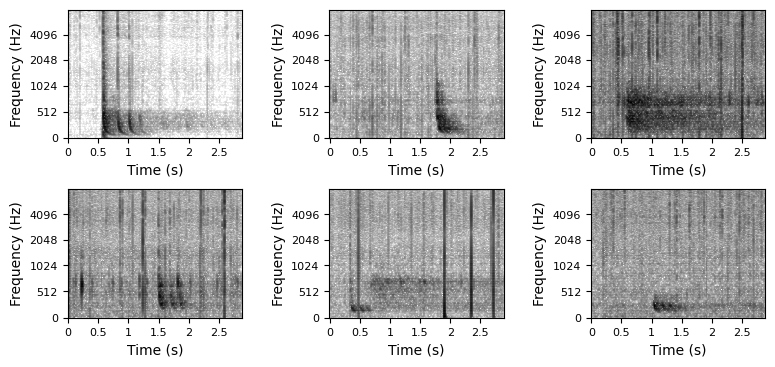

In [19]:
from typing import List, Dict
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from math import ceil

# Global constants for subplot dimensions and spacing
SPEC_WIDTH = 3      # width per subplot (in inches)
SPEC_HEIGHT = 2     # height per subplot (in inches)
SPEC_HGAP = 0.5     # horizontal gap between subplots
SPEC_VGAP = 0.2     # vertical gap between subplots

# Directory settings
AUDIO_DIR = os.path.join(BASE_DIR, "bomb_fishing/data/figures/plot_audio/final")
#OUTPUT_FILE = os.path.join(BASE_DIR, "bomb_fishing/example_bombs.png") # just save from here

# Spectrogram parameters
SR = 8000         # sampling rate
DURATION = 2.88     # seconds to load from each file
N_COLS = 3         # number of columns in the grid

def get_wav_files(folder_path: str) -> list[str]:
    """
    Return a sorted list of all .wav files in folder_path.
    """
    return sorted(
        [
            os.path.join(folder_path, f)
            for f in os.listdir(folder_path)
            if f.lower().endswith(".wav")
        ]
    )

def compute_log_mel_spectrogram(
    file_path: str, sr: int = SR, duration: float = DURATION
) -> np.ndarray:
    """
    Load up to `duration` seconds from file_path at sample rate `sr`,
    compute a Mel spectrogram, then convert to log scale (dB).
    """
    y, _ = librosa.load(file_path, sr=sr, duration=duration)
    if len(y) > sr * duration:
        y = y[: int(sr * duration)]
    mel_spec = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_fft=1024,
        win_length=512,
        hop_length=128,
        window="hann",
        pad_mode="constant",
        power=2.0,
        fmax=4000,
        n_mels=512,
    )
    return librosa.power_to_db(mel_spec, ref=np.max)

def plot_spectrogram_grid(
    spectrograms: list[np.ndarray],
    titles: list[str],
    ncols: int = N_COLS,
    sr: int = SR,
    duration: float = DURATION,
    output_file: str | None = None,
) -> None:
    """
    Plot a grid of Mel spectrograms (log scale) for each item in `spectrograms`.
    - `titles` should match the length of `spectrograms`.
    - Uses `ncols` columns; number of rows is auto-computed.
    - If `output_file` is not None, saves the figure there.
    """
    n_files = len(spectrograms)
    nrows = ceil(n_files / ncols)
    figsize = (ncols * 3, nrows * 2)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, constrained_layout=False)
    plt.subplots_adjust(wspace=0.5, hspace=0.4)

    # Flatten axes array or wrap single axis in list for consistency
    if n_files == 1:
        axes = [axes]  # single subplot
    else:
        axes = axes.flatten()

    for i, (spec, title) in enumerate(zip(spectrograms, titles)):
        ax = axes[i]
        librosa.display.specshow(
            spec,
            sr=sr,
            x_axis="time",
            y_axis="mel",
            fmax=8000,
            ax=ax,
            cmap="gray_r",  # reversed gray so hotter regions are darker
            x_coords=np.linspace(0, duration, spec.shape[1]),
        )
        #ax.set_title(title, fontsize=12, fontweight="bold")
        ax.set_xlabel("Time (s)", fontsize=10)
        ax.set_ylabel("Frequency (Hz)", fontsize=10)
        ax.tick_params(axis="x", labelsize=8, direction="out")
        ax.tick_params(axis="y", labelsize=8, direction="out")

    # Remove any extra subplots
    for j in range(n_files, len(axes)):
        fig.delaxes(axes[j])

    save_path = os.path.join(BASE_DIR, "bomb_fishing/data/figures", f"bomb_examples.png")
    plt.savefig(save_path, dpi=600, bbox_inches="tight", transparent=True)
    plt.show()

wav_files = get_wav_files(AUDIO_DIR)
spectrograms = [compute_log_mel_spectrogram(f) for f in wav_files]
titles = [os.path.basename(f) for f in wav_files]
plot_spectrogram_grid(spectrograms, titles)


## Map
Ripped right from my other PhD chapter so is a bit over engineered: https://github.com/BenUCL/MARRS_global_acoustic_study/blob/main/manuscript_docs/figures.ipynb

In [20]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import math
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

import os
import math
from typing import Union, Tuple

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Global variables (BASE_DIR is already set)
BUFFER = 500
COLOUR_MAPPING = {"B": 'black', "H": "#1b7837", "D": "#500072", "N": "#c2a5cf", "R": "#acd39e"}
DOT_EDGE_WIDTH = 1.5  # Outline width for dots


def add_north_arrow(ax, location: Union[str, Tuple[float, float]] = "upper left", zoom: float = 0.08) -> None:
  """Add a north arrow from an image file.

  Parameters:
    ax: The matplotlib axes.
    location: Either a tuple (in axes fraction) or a string keyword for position.
    zoom: Zoom factor for the arrow image.
  """
  # Map location string to axes fraction coordinates
  pos_dict = {
      "upper left": (0.1, 0.87),
      "upper right": (0.95, 0.9),
      "lower left": (0.05, 0.05),
      "lower right": (0.93, 0.12),
      "center": (0.5, 0.5)
  }
  loc = pos_dict.get(location.lower(), (0.05, 0.95)) if isinstance(location, str) else location
  img_path = os.path.join(BASE_DIR, "marrs_acoustics/data/figures/north_arrow_pixabay.png")
  img = mpimg.imread(img_path)
  imagebox = OffsetImage(img, zoom=zoom)
  ab = AnnotationBbox(imagebox, loc, xycoords="axes fraction", frameon=False)
  ax.add_artist(ab)

def add_scalebar(ax: plt.Axes, 
                 length: float, 
                 location: Union[str, Tuple[float, float]] = "lower left",
                 tick_count: int = 5, 
                 thickness: float = 2.5,
                 pos_override: dict = None) -> None:
  """Add a customised scale bar with tick marks.
  
  Parameters:
    ax: The matplotlib axes.
    length: The scale bar length in data units (e.g. metres).
    location: Either a tuple (in axes fraction) or a string keyword for position.
    tick_count: Number of tick marks (including endpoints).
    thickness: Line thickness for the bar and ticks.
    pos_override: Optional dictionary to override default position mapping.
  """
  pos_dict = {
      "upper left": (0.05, 0.95),
      "upper right": (-0.5, -0.5),
      "lower left": (-0.06, 0.08),
      "lower right": (0.95, 0.2),
      "center": (0.5, 0.5)
  }
  if pos_override:
      pos_dict.update(pos_override)
  loc_frac = pos_dict.get(location.lower(), (0.05, 0.05)) if isinstance(location, str) else location
  # Convert axes fraction to data coordinates
  start_disp = ax.transAxes.transform(loc_frac)
  start_data = ax.transData.inverted().transform(start_disp)
  x0, y0 = start_data[0], start_data[1]
  # Draw the horizontal scale bar
  ax.plot([x0, x0 + length], [y0, y0], color="black", linewidth=thickness, zorder=10)
  # Draw tick marks along the bar (ticks drawn downward)
  for i in range(tick_count):
      tick_x = x0 + i * (length / (tick_count - 1))
      tick_pixels = 10  # tick height in pixels
      tick_disp_start = ax.transData.transform((tick_x, y0))
      tick_disp_end = (tick_disp_start[0], tick_disp_start[1] - tick_pixels)
      tick_data_end = ax.transData.inverted().transform(tick_disp_end)
      tick_length = y0 - tick_data_end[1]
      ax.plot([tick_x, tick_x], [y0, y0 - tick_length], color="black", linewidth=thickness, zorder=10)
  # Place the label above the middle tick
  mid_x = x0 + length / 2
  ax.annotate(f"{length/1000:.1f} km", xy=(mid_x, y0), xytext=(0, 15),
              textcoords="offset points", ha="center", va="bottom",
              fontsize=20, color="black", zorder=10)


# Custom tick formatter: convert EPSG:3857 x (meters) to approximate longitude (degrees)
def make_x_formatter(decimals=2):
    fmt = f"{{:.{decimals}f}}"
    def x_formatter(x, pos):
        return fmt.format(x/6378137*180/math.pi)
    return x_formatter

def make_y_formatter(decimals=2):
    fmt = f"{{:.{decimals}f}}"
    def y_formatter(y, pos):
        lat = (math.pi/2 - 2*math.atan(math.exp(-y/6378137)))*180/math.pi
        return fmt.format(lat)
    return y_formatter

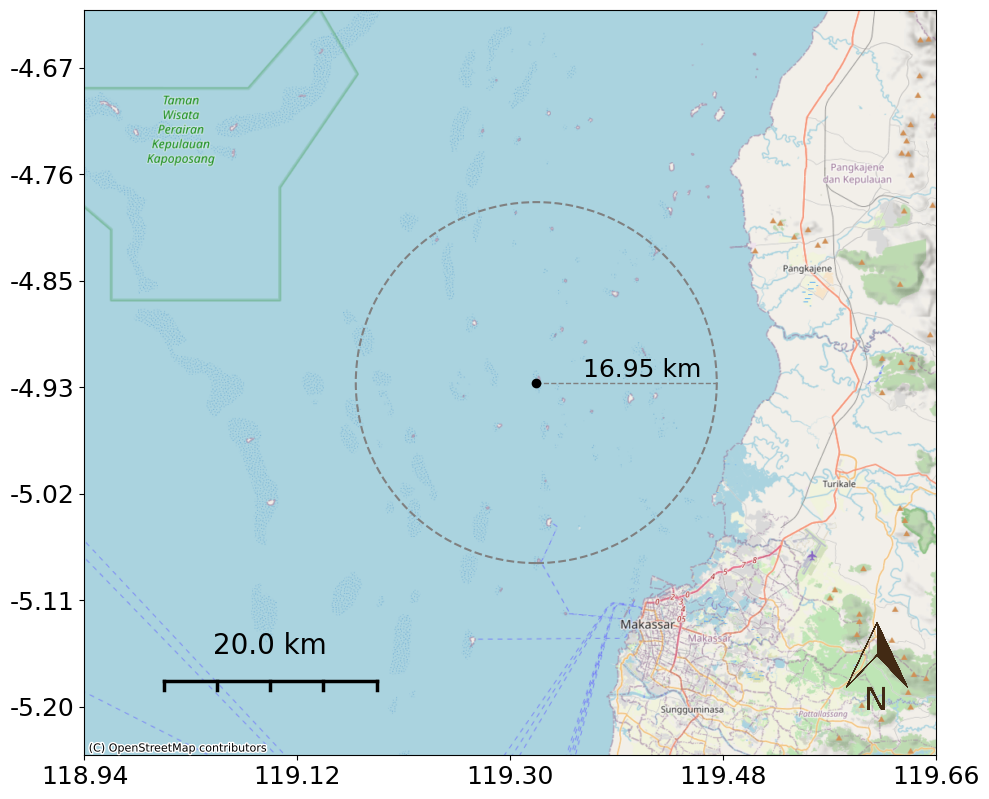

In [21]:
from matplotlib.patches import Circle


MAP = 'indonesia_zoom_out'
ZOOM =35000 # In metres
SCALE_BAR_LEN = 20000 # in metries
SCALE_BAR_POS = {"lower left": (-0.00, 0.1)} # x and y, can set as negative vals if needed

# Read CSV and create GeoDataFrame in EPSG:4326 then convert to EPSG:3857
df = pd.read_csv(os.path.join(BASE_DIR, "marrs_acoustics/data/figures/site_maps/" + MAP + ".csv"))
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.Longitude, df.Latitude),
    crs="EPSG:4326"
)
gdf = gdf.to_crs(epsg=3857)

# Compute bounds with a buffer (in metres)
if len(gdf) == 1:
    # For a single point, set a default half-extent (e.g. 500 km) for a zoomed-out view
    xmid = gdf.geometry.x.iloc[0]
    ymid = gdf.geometry.y.iloc[0]
    half_extent = ZOOM  # adjust as needed for Queensland's coast
else:
    xmin, ymin, xmax, ymax = gdf.total_bounds
    xmin, ymin, xmax, ymax = xmin - BUFFER, ymin - BUFFER, xmax + BUFFER, ymax + BUFFER
    xmid = (xmin + xmax) / 2
    ymid = (ymin + ymax) / 2
    half_extent = max(xmax - xmin, ymax - ymin) / 2


square_xlim = (xmid - half_extent, xmid + half_extent)
square_ylim = (ymid - half_extent, ymid + half_extent)

# Create colours list based on the first letter of "new_name"
colors = [COLOUR_MAPPING.get(name[0], "black") for name in gdf["new_name"]]

fig, ax = plt.subplots(figsize=(10, 10))

# Plot points with a black outline
gdf.plot(
    ax=ax,
    color=colors,
    markersize=30,
    edgecolor="black",
    linewidth=DOT_EDGE_WIDTH,
    zorder=5,
)


### Draw the radius 
# Draw a dashed red radius line at a 320° angle above horizontal
center = gdf.geometry.iloc[0]
radius_m = 16_950  # 16.95 km

x0, y0 = center.x, center.y
angle = np.deg2rad(0)          # tilt angle (in radians)
dx = radius_m * np.cos(angle)   # horizontal component
dy = radius_m * np.sin(angle)   # vertical component
x1, y1 = x0 + dx, y0 + dy

# plot the line
ax.plot([x0, x1], [y0, y1],
        color="grey",
        linestyle="--",
        linewidth=1)

# Label at the midpoint of the tilted line (and shift a bit left)
mid_x, mid_y = x0 + ((dx/2)+ 7000), (y0 +100) + dy/2
ax.text(mid_x, mid_y,
        "16.95 km",
        color="black",
        fontsize=18,
        ha="right",    # align text to the left of its anchor
        va="bottom")  # put text just above the line

# plot the circle
circle = Circle(
    (x0, y0),
    radius=radius_m,
    edgecolor="grey",
    facecolor="none",
    linestyle="--",
    linewidth=1.5,
    zorder=4  # slightly below the point markers
)
ax.add_patch(circle)
###


ax.set_xlim(square_xlim)
ax.set_ylim(square_ylim)
ax.set_aspect("equal", adjustable="box")

# Add a basemap
basemap_provider = ctx.providers.OpenStreetMap.CH
ctx.add_basemap(ax, source=basemap_provider)

# Add north arrow and scale bar (assumed defined elsewhere)
add_north_arrow(ax, location="lower right", zoom=0.05)
add_scalebar(ax, length=SCALE_BAR_LEN, pos_override=SCALE_BAR_POS)
ax.xaxis.set_ticks_position("bottom")
ax.yaxis.set_ticks_position("left")
ax.tick_params(axis="both", labelsize=18)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(make_x_formatter(decimals=2)))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(make_y_formatter(decimals=2)))
ticks = ax.get_xticks()
ax.set_xticks(ticks[::2])

plt.tight_layout()
save_path = os.path.join(BASE_DIR, "bomb_fishing/data/figures", f"main_map.png")
plt.savefig(save_path, dpi=600, bbox_inches="tight", transparent=True)
plt.show()

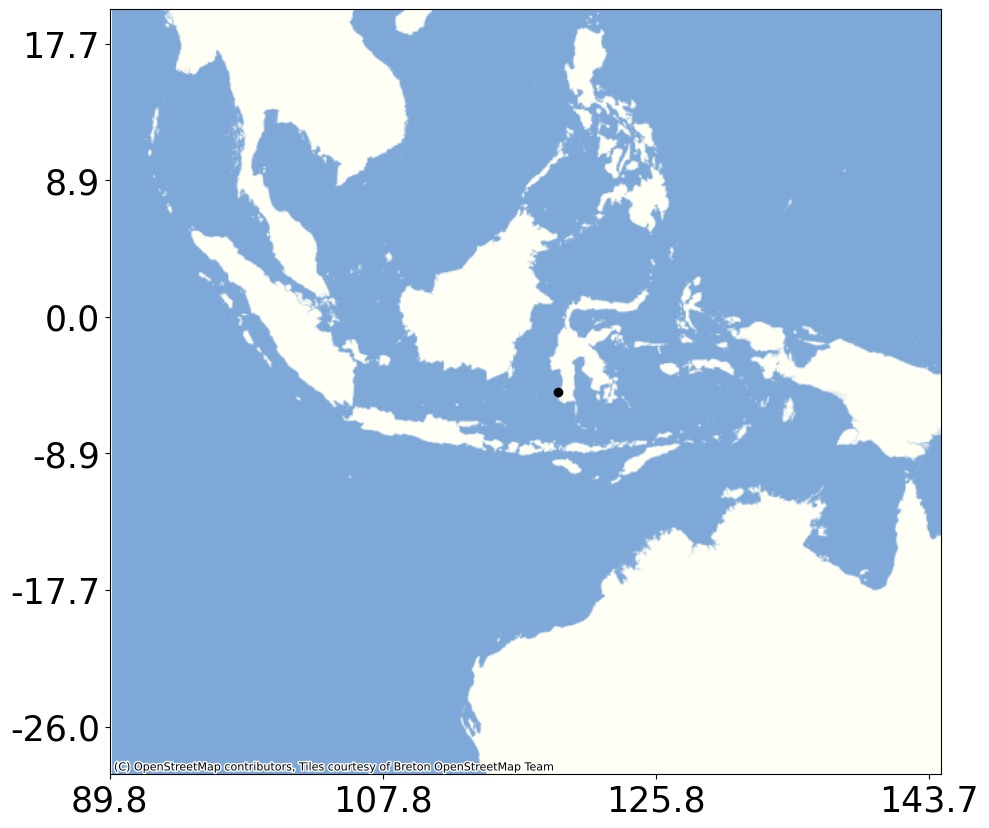

In [22]:
from matplotlib.patches import Circle


MAP = 'indonesia_zoom_out'
ZOOM =2800000 # In metres
SCALE_BAR_LEN = 20000 # in metries
SCALE_BAR_POS = {"lower left": (-0.00, 0.1)} # x and y, can set as negative vals if needed

# Read CSV and create GeoDataFrame in EPSG:4326 then convert to EPSG:3857
df = pd.read_csv(os.path.join(BASE_DIR, "marrs_acoustics/data/figures/site_maps/" + MAP + ".csv"))
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.Longitude, df.Latitude),
    crs="EPSG:4326"
)
gdf = gdf.to_crs(epsg=3857)

# Compute bounds with a buffer (in metres)
if len(gdf) == 1:
    # For a single point, set a default half-extent (e.g. 500 km) for a zoomed-out view
    xmid = gdf.geometry.x.iloc[0]
    ymid = gdf.geometry.y.iloc[0]
    half_extent = ZOOM  # adjust as needed for Queensland's coast
else:
    xmin, ymin, xmax, ymax = gdf.total_bounds
    xmin, ymin, xmax, ymax = xmin - BUFFER, ymin - BUFFER, xmax + BUFFER, ymax + BUFFER
    xmid = (xmin + xmax) / 2
    ymid = (ymin + ymax) / 2
    half_extent = max(xmax - xmin, ymax - ymin) / 2


square_xlim = (xmid - half_extent, xmid + half_extent)
square_ylim = (ymid - half_extent, ymid + half_extent)

# Create colours list based on the first letter of "new_name"
colors = [COLOUR_MAPPING.get(name[0], "black") for name in gdf["new_name"]]

fig, ax = plt.subplots(figsize=(10, 10))

# Plot points with a black outline
gdf.plot(
    ax=ax,
    color=colors,
    markersize=30,
    edgecolor="black",
    linewidth=DOT_EDGE_WIDTH,
    zorder=5,
)



ax.set_xlim(square_xlim)
ax.set_ylim(square_ylim)
ax.set_aspect("equal", adjustable="box")

# Add a basemap
basemap_provider = ctx.providers.OpenStreetMap.BZH #.BZH for no labels, .HOT for nice borders but has labels
ctx.add_basemap(ax, source=basemap_provider)

# Add north arrow and scale bar (assumed defined elsewhere)
#add_north_arrow(ax)
#add_scalebar(ax, length=SCALE_BAR_LEN, pos_override=SCALE_BAR_POS)
ax.xaxis.set_ticks_position("bottom")
ax.yaxis.set_ticks_position("left")
ax.tick_params(axis="both", labelsize=25)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(make_x_formatter(decimals=1)))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(make_y_formatter(decimals=1)))
ticks = ax.get_xticks()
ax.set_xticks(ticks[::2])

plt.tight_layout()
save_path = os.path.join(BASE_DIR, "bomb_fishing/data/figures", f"submap_label_free.png")
plt.savefig(save_path, dpi=600, bbox_inches="tight", transparent=True)
plt.show()